In [23]:
# provide project root path
ProjectRoot = ""
DatasetRoot = ProjectRoot + "manuals/"

In [24]:
# Miscellaneous
import json
import regex as re
import numpy as np
import pandas as pd
import torch

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Concurrency
import concurrent.futures

# Machine Learning and NLP
from sentence_transformers import SentenceTransformer

#Baseline model
from rank_bm25 import BM25Okapi
# Database
import chromadb

### Loading and Preprocessing the Dataset

In this cell, we load a dataset from a CSV file and perform basic preprocessing:

1. **Load the Dataset**: We load the CSV file into a pandas DataFrame using `pd.read_csv()`.
2. **Remove Missing Data**: We drop rows where the `question` or `answer` columns are missing.
3. **Remove Duplicates**: We remove any duplicate rows based on the `para_id` column, keeping only the first occurrence.
4. **Reset Index**: We reset the DataFrame index and store the original index in a new column called `para_id_index`.
5. **Extract Raw Text**: We create a list of paragraph text (`sentence_chunk`) and their corresponding unique identifiers (`para_id_index`).

This process ensures that the dataset is clean and ready for further analysis or use in tasks like document retrieval or question answering.


In [25]:
# loading full article from json file
df = None
file_path = DatasetRoot + '/Fraggles_X700_2022_HCM_QA_Curated.csv'
df = pd.read_csv(file_path,  encoding='latin1')

#keep only one question per chunk
df.dropna(subset=['question', 'answer'], inplace=True)
df = df.drop_duplicates(subset=['para_id'], keep='first')
df = df.reset_index(drop=False)  # Adds the index as a new column
df =df.reset_index(drop=False)
df = df.rename(columns={"level_0": "para_id_index"})
raw_text_list = df['sentence_chunk']
raw_text_ids = df['para_id_index']

In [26]:
df.head()

,para_id_index,index,page_number,para_id,sentence_chunk,question,answer
0,0,0,1,e6c45229dc996b6ba2ecb9ddb251f77c5ee3f2de93cc1d...,check that the rod is ï¬rmly placed to avoid ...,What should you do to prevent the hood from ac...,"Before closing the hood, make sure the support..."
1,1,3,1,69dedd5e3d5bbf7c8e9a12176d60789e110a65cd533d26...,"If you feel any resistance, stop and check fo...",What should you do if you feel resistance when...,"f you feel any resistance, stop immediately an..."
2,2,6,1,fc843f5ed9e92f0a42868ed7813e7c197902b5f2194f87...,Pull the hood release handle: The hood release...,Where is the hood release handle typically loc...,The hood release handle is usually located in ...
3,3,9,1,0c927bca6c80fe20d270cb43d62ea95099483181509007...,The support rod is typically located on the u...,Where is the support rod typically located in ...,The support rod is typically located on the un...
4,4,12,2,560865acae00a7a1c7b35d8567b972195079a68eddcf40...,Genuine FragglesX700HCM Motor Oil (for optimal...,What are the benefits of using Genuine Fraggle...,Genuine FragglesX700HCM Motor Oil is a premium...


### Evaluating Retrieval Performance of Embeddings
E evaluaate the performance of different embeddings in a retrieval task using three metrics: **Precision**, **Recall**, and **Mean Reciprocal Rank (MRR)**.

1. **Metrics Definition**:
   - **Precision at k**: Measures the proportion of relevant documents (ground truth) in the top-k retrieved documents.
   - **Recall at k**: Measures the proportion of relevant documents retrieved out of all relevant documents.
   - **MRR (Mean Reciprocal Rank)**: Measures the rank at which the first relevant document appears in the retrieved list, rewarding systems that return relevant documents early.

2. **Function Workflow**:
   - The function `evaluate_retrieval()` takes an embedding model, a retriever, and an evaluation dataset.
   - For each query in the dataset:
     - It retrieves the corresponding paragraph (ground truth) for the query.
     - It then embeds the query using the given embedding model and searches for the most relevant documents.
     - It calculates precision, recall, and MRR based on whether the retrieved documents match the ground truth.

3. **Output**: 
   - The function returns the average precision, recall, and MRR across all queries in the evaluation dataset.
   - These metrics are collected and stored in a DataFrame `embeddings_metrics_df` for further analysis or comparison of different embeddings.

This function helps assess the retrieval effectiveness of various embeddings by computing how well they match relevant documents for a given query.


In [27]:
# dataframe holding metrics for different embeddings
embeddings_metrics_df = pd.DataFrame(columns=['Embedding', 'Precision', 'Recall', 'MRR'])

# calculate Retrieval Precision, Recall, MRR
def evaluate_retrieval(embed_model, retriever, eval_dataset, top_n=3):
    precision_at_k = []
    recall_at_k = []
    mrr = []

    for _, eval_data in eval_dataset.iterrows():

        # get query and raw paragraph ID from where question was generated.
        # This paragraph will be treated as ground truth doc
        raw_para_id = eval_data['para_id_index']
        query = eval_data['question']

        # embed query into vector
        query_embedding = embed_model.encode(query).tolist()
        # search most relevant docs
        retrieved_docs = retriever.query(query_embeddings=query_embedding, n_results=top_n)
        doc_indices = [int(idx) for idx in retrieved_docs['ids'][0]]

        relevant_docs = set([raw_para_id])
        retrieved_docs = set(doc_indices)

        hits = relevant_docs & retrieved_docs

        # calculate precision, recall
        precision = len(hits) / len(retrieved_docs)
        recall = len(hits) / len(relevant_docs)

        precision_at_k.append(precision)
        recall_at_k.append(recall)

        # calculate MRR
        reciprocal_rank = 0.0
        for rank, doc_index in enumerate(doc_indices, start=1):
            if doc_index in relevant_docs:
                reciprocal_rank = 1.0 / rank
                break
        mrr.append(reciprocal_rank)

    avg_precision = np.mean(precision_at_k)
    avg_recall = np.mean(recall_at_k)
    avg_mrr = np.mean(mrr)

    return avg_precision, avg_recall, avg_mrr

### Evaluating BM25 Baseline
S set up a **BM25** baseline for document retrieval:

1. **BM25 Model**:
   - **BM25** (Best Matching 25) is a popular ranking function used in information retrieval. It ranks documents based on the presence of query terms, considering factors like term frequency and document length.
   
2. **Tokenizing the Corpus**:
   - The raw text documents (`raw_text_list`) are tokenized into a list of words. This step is required because BM25 operates on tokenized text (list of words) rather than raw text.

3. **BM25 Retriever Setup**:
   - The tokenized corpus is passed to `BM25Okapi`, which initializes the BM25 retrieval model.
   - The `bm25_retriever` object can now be used to perform retrieval tasks, such as searching for the most relevant documents based on a query.

This setup allows us to evaluate the BM25 model by comparing its performance (e.g., precision, recall, MRR) with other more advanced embeddings-based retrieval methods.

https://pypi.org/project/rank-bm25/

In [28]:
def evaluate_retrieval_bm25(bm25, eval_dataset, top_n=3):
    precision_at_k = []
    recall_at_k = []
    mrr = []

    for _, eval_data in eval_dataset.iterrows():
        # Get query and raw paragraph ID (ground truth doc)
        raw_para_id = eval_data['para_id_index']
        query = eval_data['question']

        # Search for the most relevant documents using BM25
        scores = bm25.get_scores(query)
        sorted_doc_indices = np.argsort(-scores)[:top_n]

        # Set of relevant documents and retrieved documents
        relevant_docs = set([raw_para_id])  # For a single relevant doc
        retrieved_docs = set(sorted_doc_indices)

        # print(relevant_docs)
        # print('retrieved_docs: ', retrieved_docs)

        hits = relevant_docs & retrieved_docs  # Intersection of relevant and retrieved docs

        # Calculate Precision and Recall
        precision = len(hits) / len(retrieved_docs) if len(retrieved_docs) > 0 else 0.0
        recall = len(hits) / len(relevant_docs) if len(relevant_docs) > 0 else 0.0

        precision_at_k.append(precision)
        recall_at_k.append(recall)

        # Calculate MRR (Mean Reciprocal Rank)
        reciprocal_rank = 0.0
        for rank, doc_index in enumerate(sorted_doc_indices, start=1):
            if doc_index in relevant_docs:
                reciprocal_rank = 1.0 / rank
                break
        mrr.append(reciprocal_rank)

    # Calculate average metrics
    avg_precision = np.mean(precision_at_k)
    avg_recall = np.mean(recall_at_k)
    avg_mrr = np.mean(mrr)

    return avg_precision, avg_recall, avg_mrr

### Evaluating BM25 with Precision, Recall, and MRR

Calculate and print the **Precision**, **Recall**, and **Mean Reciprocal Rank (MRR)** for the BM25 model. The results are then recorded in a DataFrame for comparison with other embeddings.

1. **Calculate Metrics**:
   - We use the `evaluate_retrieval_bm25()` function to calculate the retrieval performance of the BM25 model on the evaluation dataset (`df[['para_id_index', 'question']]`).
   - This function returns three key metrics:
     - **Precision**: The proportion of relevant documents in the top-k retrieved documents.
     - **Recall**: The proportion of relevant documents retrieved out of all possible relevant documents.
     - **MRR**: The rank at which the first relevant document appears, with higher values indicating better performance.

2. **Print Results**:
   - After calculating the metrics, we print the values of Precision, Recall, and MRR to assess the model's performance.

3. **Store Results**:
   - The results are stored in a new row in a DataFrame (`new_row`), which contains the metrics for the BM25 model (`Embedding`, `Precision`, `Recall`, `MRR`).
   - This new row is appended to the `embeddings_metrics_df` DataFrame, which holds the metrics for different models and embeddings.

This process allows us to track and compare the performance of BM25 against other retrieval models.


In [29]:
from rank_bm25 import BM25Okapi
model_name = 'BM25'
tokenized_corpus = [doc.split(" ") for doc in raw_text_list]  # Tokenize raw documents
bm25_retriever = BM25Okapi(tokenized_corpus)

# calculate precision, recall, mrr
precision, recall, mrr = evaluate_retrieval_bm25(bm25_retriever, df[['para_id_index', 'question']])

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, MRR: {mrr:.4f}")

# record results
new_row = pd.DataFrame({
    'Embedding': [model_name],
    'Precision': [precision],
    'Recall': [recall],
    'MRR': [mrr]
})
embeddings_metrics_df = pd.concat([embeddings_metrics_df, new_row], ignore_index=True)

Precision: 0.0112, Recall: 0.0337, MRR: 0.0206


/tmp/ipykernel_3639414/1396288618.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  embeddings_metrics_df = pd.concat([embeddings_metrics_df, new_row], ignore_index=True)


### Evaluating Multiple Embedding Models

In this cell, we evaluate multiple sentence transformer models and store their retrieval performance metrics (Precision, Recall, MRR) for comparison. The models are stored in a list, and each model is evaluated in a loop.

1. **Model List**:
   - A list of **sentence transformer models** is defined. These models are pre-trained embeddings, which can be used for various natural language processing tasks such as text retrieval.

2. **Loop Over Models**:
   - The loop iterates over each model in the list:
     - For each model:
       - **Embed the Text**: The `SentenceTransformer` model is used to encode the `raw_text_list` (the text of paragraphs) into embeddings (numerical vectors).
       - **Chroma Database Setup**: The embeddings are added to a Chroma collection. Each model's embeddings are stored in a separate collection, named using the model's name.
       - **Retriever Setup**: A retriever is created from the Chroma collection, which will be used for searching the relevant documents during evaluation.

3. **Evaluate Retrieval**:
   - The `evaluate_retrieval()` function is called to calculate **Precision**, **Recall**, and **MRR** for each model's retrieval performance. These metrics are computed by comparing the retrieved documents to the ground truth (relevant documents).
   
4. **Store Results**:
   - The metrics for each model are stored in a new row (`new_row`) and appended to a DataFrame `embeddings_metrics_df` for comparison.

5. **Results**:
   - After all models have been evaluated, the metrics for each model are stored in the `embeddings_metrics_df` DataFrame, allowing for easy comparison of their performance.

This process allows us to evaluate and compare the retrieval performance of various sentence transformer models for document retrieval tasks.


In [30]:
# List of models to evaluate
models = [
    'sentence-transformers/all-mpnet-base-v2',
    'sentence-transformers/all-MiniLM-L6-v2',
    'sentence-transformers/average_word_embeddings_glove.840B.300d',
    'sentence-transformers/multi-qa-mpnet-base-dot-v1',
    'sentence-transformers/multi-qa-mpnet-base-cos-v1',
    'sentence-transformers/all-distilroberta-v1',
    'colbert-ir/colbertv2.0'
]

# Loop over models and evaluate each one
for model_name in models:
    # Sentence transformer models
    model = SentenceTransformer(model_name)
    embeddings = [model.encode(text).tolist() for text in raw_text_list]
    
    # Setup Chroma client and collection
    client = chromadb.PersistentClient(path='chroma_db_dir')

    collectionname = model_name.replace('sentence-transformers/', '')
    collection_name = f"knowledge-store-{re.sub('[^a-zA-Z]', '', collectionname)}"

    retriever = client.get_or_create_collection(collection_name)

    raw_text_ids = raw_text_ids.astype(str)

    # Add documents and embeddings to the collection
    retriever.add(
        embeddings=embeddings,
        documents=raw_text_list.tolist(),
        ids=raw_text_ids.tolist()
    )
    
    # Evaluate retrieval performance using the evaluate_retrieval function
    precision, recall, mrr = evaluate_retrieval(model, retriever, df[['para_id_index', 'question']])

    #print(model_name, precision, recall, mrr)
    
    # Append results to DataFrame
    new_row = pd.DataFrame({
        'Embedding': [model_name],
        'Precision': [precision],
        'Recall': [recall],
        'MRR': [mrr]
    })
    embeddings_metrics_df = pd.concat([embeddings_metrics_df, new_row], ignore_index=True)

# Print the results after all models have been evaluated
#print(embeddings_metrics_df)



Add of existing embedding ID: 0
Add of existing embedding ID: 1
Add of existing embedding ID: 2
Add of existing embedding ID: 3
Add of existing embedding ID: 4
Add of existing embedding ID: 5
Add of existing embedding ID: 6
Add of existing embedding ID: 7
Add of existing embedding ID: 8
Add of existing embedding ID: 9
Add of existing embedding ID: 10
Add of existing embedding ID: 11
Add of existing embedding ID: 12
Add of existing embedding ID: 13
Add of existing embedding ID: 14
Add of existing embedding ID: 15
Add of existing embedding ID: 16
Add of existing embedding ID: 17
Add of existing embedding ID: 18
Add of existing embedding ID: 19
Add of existing embedding ID: 20
Add of existing embedding ID: 21
Add of existing embedding ID: 22
Add of existing embedding ID: 23
Add of existing embedding ID: 24
Add of existing embedding ID: 25
Add of existing embedding ID: 26
Add of existing embedding ID: 27
Add of existing embedding ID: 28
Add of existing embedding ID: 29
Add of existing embe

### Visualizing Model Comparison: Precision, Recall, and MRR

In this cell, we plot a **bar chart** to compare the **Precision**, **Recall**, and **MRR** scores across different embedding models evaluated previously.

1. **Melt the DataFrame**:
   - The `embeddings_metrics_df` is "melted" using `pd.melt()` to reshape it for plotting. This step converts the data from a wide format to a long format, where each metric (Precision, Recall, MRR) becomes a separate row for each embedding model.
   - The `Embedding` column holds the model names, and the `Metric` and `Value` columns contain the metric type (Precision, Recall, MRR) and the corresponding score.

2. **Plot the Data**:
   - A **bar plot** is created using `sns.barplot()` to visualize the comparison of the metrics for each embedding model.
   - The x-axis shows the model names, and the y-axis represents the metric score.
   - Different colors (based on the `hue='Metric'`) are used to distinguish between Precision, Recall, and MRR.

3. **Customize the Plot**:
   - The plot is customized with labels, a title, and a legend. The x-axis labels (model names) are rotated for better readability.
   - The y-axis is limited to the range between 0.0 and 1.5 to better visualize the metric values.

4. **Display the Plot**:
   - The plot is displayed using `plt.show()`.

This visualization helps to easily compare the performance of different models in terms of Precision, Recall, and MRR.


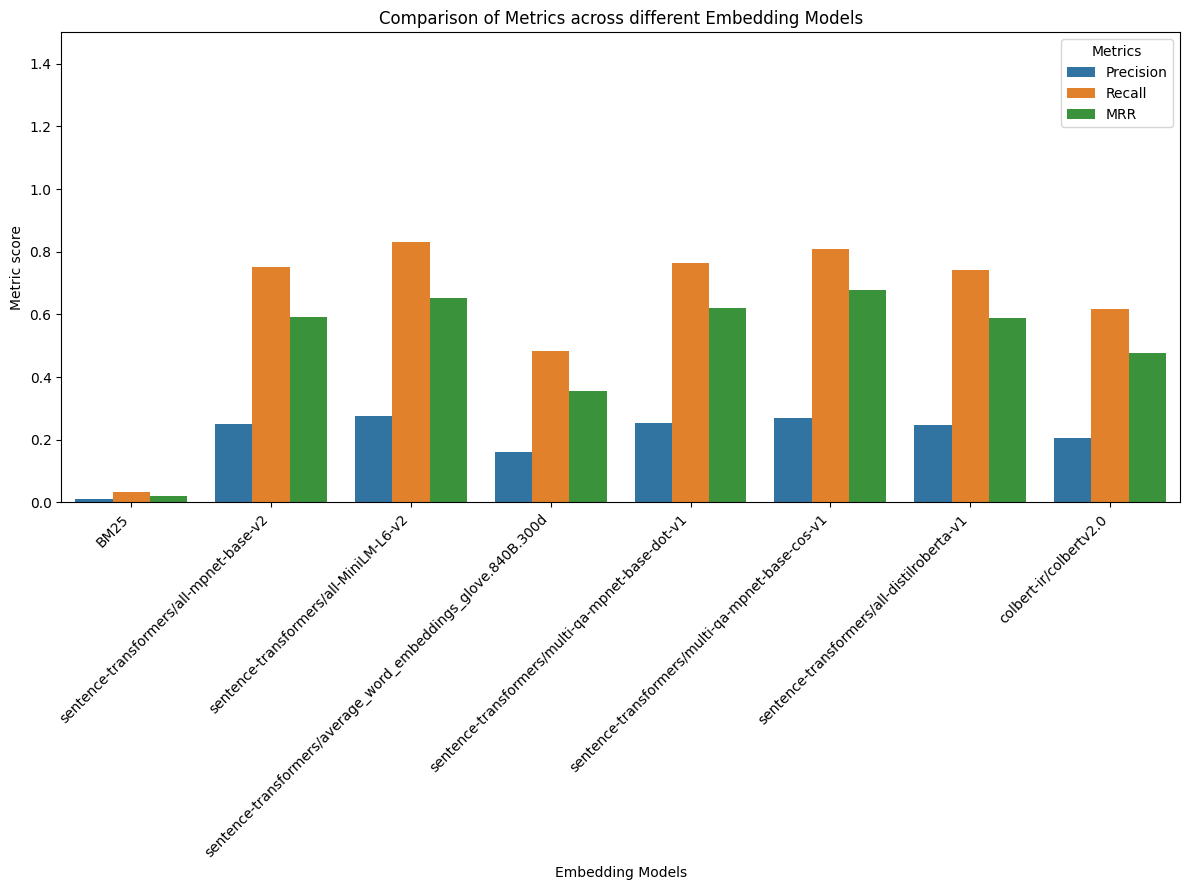

In [31]:
# melt df to plot Precision, Recall, MRR
melted_df = embeddings_metrics_df.melt(id_vars='Embedding', var_name='Metric', value_name='Value')

# Plot
plt.figure(figsize=(12, 9))
sns.barplot(data=melted_df, x='Embedding', y='Value', hue='Metric')
plt.title('Comparison of Metrics across different Embedding Models')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Embedding Models')
plt.ylabel('Metric score')
plt.ylim(0.0, 1.5)
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()